# 논문 살펴보기

[Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [6]:
import torch

# 활성화 함수(Activation Function)
> 인공신경망에서 비선형성을 담당

- 현실 세계의 데이터는 비선형 데이터입니다.   
- 비선형 함수가 없다면 레이어를 쌓아봤자 의미가 없어집니다. ([참고](https://junstar92.tistory.com/122))

[결정 바운더리](https://playground.tensorflow.org/)

## tanh

(사실 최신 모델에서는 잘 안 씁니다)

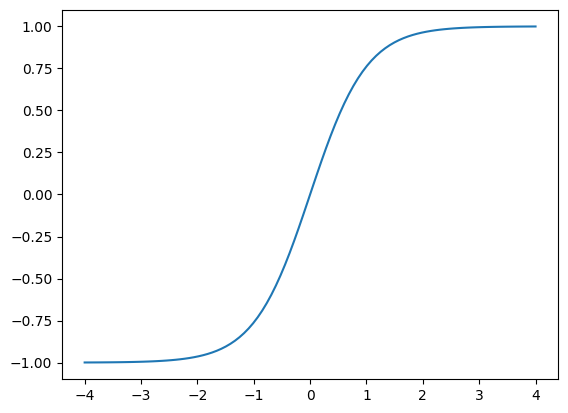

In [7]:
import matplotlib.pyplot as plt

x = torch.linspace(-4, 4, 100)
y = torch.tanh(x)

plt.plot(x, y)

## ReLU

요즘 모델들은 `ReLU`나 파생된 함수를 많이 씁니다 (`GeLU` 등)

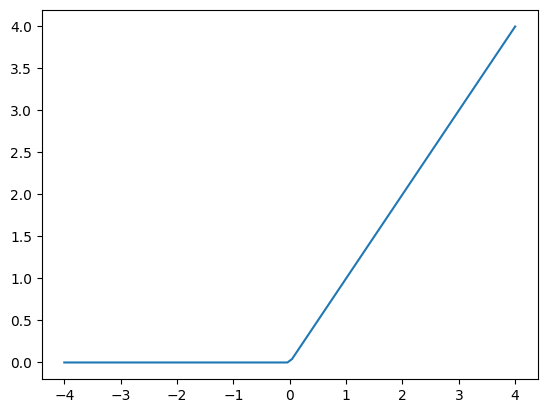

In [8]:
x = torch.linspace(-4, 4, 100)
y = torch.relu(x)

plt.plot(x, y)

# 데이터셋 구축

In [9]:
names = open('../names.txt').read().splitlines()

chars = sorted(list(set(''.join(names))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

In [10]:
import torch

block_size = 3 # context window
X,Y = [], []
for name in names[:5]: # 일단 5개 이름으로만 만들기

    print(name)
    context = [0] * block_size # 맨 처음에는 ...으로 시작

    for ch in name + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', ch)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [11]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

# embedding lookup table 만들기

In [12]:
C = torch.randn(27, 2)

In [13]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

## 원핫 벡터 안쓰는 이유
전 시간에는 `F.one_hot()`를 사용해서 행렬곱으로 계산했습니다. (`xenc @ W`)

이러면 수많은 0을 가지고 연산을 많이 해야 해서 **비효율적**입니다.

# hidden layer 만들기

In [14]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [15]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape

torch.Size([32, 100])

b1이 브로드캐스팅됩니다!

# output layer 만들기

In [16]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [17]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

# NLL loss 만들기

In [18]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
loss = - probs[torch.arange(32), Y].log().mean()
loss

tensor(15.2054)

# 모델 전체 요약

In [19]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [20]:
sum(p.nelement() for p in parameters)

3481

In [21]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
loss = - probs[torch.arange(32), Y].log().mean()

loss

tensor(17.7697)

# F.cross_entropy로 바꾸기

In [22]:
import torch.nn.functional as F

emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
# loss = - probs[torch.arange(32), Y].log().mean()

loss = F.cross_entropy(logits, Y)

loss

tensor(17.7697)

## F.cross_entropy 쓰는 이유 3가지
1. F.cross_entropy는 중간에 새로운 텐서를 만들 필요 없습니다.
    - 메모리 효율적으로 사용
2. 여러 연산의 조합이 아닌 하나의 cross entropy 연산(fused kernel)
    - forward 빠름
    - 계산 그래프 단순 -> backpropagation 효율적
3. floating point overflow를 방지해줍니다.

In [23]:
logits = torch.tensor([-5,-3,0,100]) 
counts = logits.exp() # e^100은 매우 큼 -> inf
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

softmax는 **offset invariance** 성질이 있습니다!

소프트맥스 $\Large\sigma(z_i)=\frac{e^{z_i}}{\sum_{i=1}^K e^{z_i}}$에서

offset c를 넣어줘도  $e^c$가 약분되어서 똑같아요

$\Large\sigma(z_i+c)=\frac{e^{z_i+c}}{\sum_{j=1}^K e^{z_i+c}} =\frac{e^{z_i}}{\sum_{i=1}^K e^{z_i}}=\sigma(z_i)$

그래서 F.cross_entropy가 logit 중 가장 큰 값 offset으로 빼줍니다.

In [24]:
logits = torch.tensor([-5,-3,0,100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

# 한 미니배치에 대해 training loop 만들기

In [26]:
import torch.nn.functional as F

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [27]:
for epoch in range(1000):
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y)
    loss.backward()
    

    for p in parameters:
        p.data -= 0.1*p.grad
        p.grad=None

print(loss.item())

0.25613853335380554


## 아무리 많이 학습해도 loss는 절대 0이 될 수 없다

학습 데이터를 다시 보겠습니다.

```
emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
```

같은 `…` 인풋에 대해 `e`, `o`, `a` 이렇게 다른 정답 값이 존재   
정답이 하나가 아니면 예측이 어려워집니다.

# 전체 배치에 대해 training loop 만들기

In [28]:
block_size = 3
X,Y = [], []
for name in names:

    # print(name)
    context = [0] * block_size

    for ch in name + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', ch)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [29]:
import torch.nn.functional as F

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

for epoch in range(10):
    
    emb = C[X] # (228146, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (228146, 100)
    logits = h @ W2 + b2 # (228146, 27)

    loss = F.cross_entropy(logits, Y)
    loss.backward()
    print(loss.item())

    for p in parameters:
        p.data -= 0.1*p.grad
        p.grad=None

19.505229949951172
17.08448600769043
15.776532173156738
14.833341598510742
14.002607345581055
13.253263473510742
12.57991886138916
11.983102798461914
11.47049331665039
11.051855087280273


한번 돌 때마다 시간이 좀 걸립니다.

# 미니배치 사용

전체 학습 데이터 중 일부만 뽑아서 학습합니다

SGD(Stochastic Gradient Descent)

In [ ]:
import torch.nn.functional as F

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

for step in range(100):
    # minibatch 적용
    ix = torch.randint(0, X.shape[0], (32,)) # batch size == 32
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y[ix])
    loss.backward()
    print(loss.item())

    for p in parameters:
        p.data -= 0.1*p.grad # lr==0.1
        p.grad=None

18.4235782623291
18.532398223876953
17.71076202392578
15.369823455810547
12.574801445007324
12.714543342590332
12.18713665008545
12.248811721801758
11.775362968444824
10.716609001159668
11.814229965209961
10.762542724609375
12.772477149963379
10.646439552307129
10.05772876739502
9.453726768493652
7.950562953948975
7.670119762420654
9.674245834350586
10.159335136413574
9.786877632141113
8.831206321716309
8.769500732421875
9.070819854736328
9.977385520935059
7.4539570808410645
9.056611061096191
7.528172016143799
6.937867641448975
7.578972816467285
6.433109283447266
7.088376045227051
7.673390865325928
7.004189968109131
6.252621173858643
6.261542320251465
5.174040794372559
6.172167778015137
8.613733291625977
6.6742377281188965
5.904501914978027
5.288675785064697
4.730935573577881
4.2587571144104
5.826840400695801
4.902585029602051
4.774261951446533
5.583516597747803
5.687109470367432
5.783446311950684
5.679170608520508
4.098951816558838
4.859870910644531
4.897696495056152
5.636178970336914

성능 평가는 쪼개지 않고 전체 데이터셋으로 합니다

In [31]:
emb = C[X] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Y)
print(loss.item())

3.7556936740875244


전체 데이터로 적게 step하는 것보다   
미니 배치로 많이 step 하는게 성능이 더 좋다고 합니다.
([참고](https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data))

컴퓨터의 RAM이나 GPU의 메모리가 작아서   
전체 데이터를 메모리에 올릴 수 없기도 하구요

# 적당한 lr 찾기

learning rate가 0.1이어야 할까요?   
적당한 lr 후보를 찾아봅시다

In [33]:
lr_exp = torch.linspace(-3, 1, 1000) # 10의 지수
lrs = 10**lr_exp

In [34]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [35]:
# 시작하기 좋은 lr 찾기

lri = []
lr_expi = []
lossi = []

for i in range(1000):
    # minibatch 적용
    ix = torch.randint(0, X.shape[0], (32,)) # batch size == 32
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y[ix])
    loss.backward()
    # print(loss.item())

    lr = lrs[i]
    for p in parameters:
        p.data -= lr*p.grad
        p.grad=None
    
    lri.append(lr)
    lr_expi.append(lr_exp[i])
    lossi.append(loss.item())

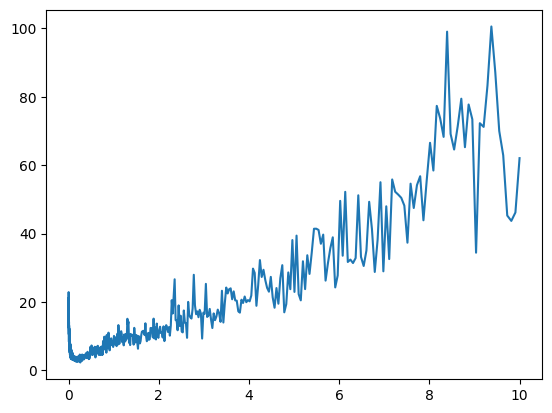

In [36]:
import matplotlib.pyplot as plt

plt.plot(lri, lossi)

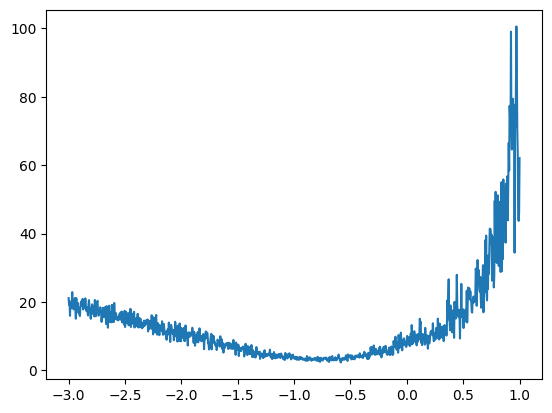

In [37]:
plt.plot(lr_expi, lossi)

대충 $0.1(=10^{-1})$ 근처가 좋아보이네요!

In [ ]:
# lr 0.1로 많이 돌리기기
for i in range(10000):
    # minibatch 적용
    ix = torch.randint(0, X.shape[0], (32,)) # batch size == 32
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y[ix])
    loss.backward()
    # print(loss.item())

    lr = 0.1
    for p in parameters:
        p.data -= lr*p.grad
        p.grad=None

In [ ]:
# loss 계산
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Y)
print(loss.item())

2.865633487701416


In [41]:
# lr 줄이기 (lr decay)
for i in range(10000):
    # minibatch 적용
    ix = torch.randint(0, X.shape[0], (32,)) # batch size == 32
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y[ix])
    loss.backward()
    # print(loss.item())

    lr = 0.01
    for p in parameters:
        p.data -= lr*p.grad
        p.grad=None

In [42]:
# loss 계산
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Y)
print(loss.item())

2.7635879516601562


실제로 이렇게 수동으로 lr을 줄이진 않습니다.   
`adam`같은 다른 최적화 방식(옵티마이저)이 알아서 lr을 조정해줍니다.

학습이 많이 진행될수록 lr이 작아지면 더 세밀하게 학습할 수 있어서   
loss를 줄일 수 있다는 흐름만 알고 갑시다!

# 데이터셋 나누기

## 과적합
모델 크기가 커지면(레이어가 깊어진다면) 학습 데이터에 **과적합(Overfitting)**됩니다.   
모델(함수)가 더 많은 정보를 담게되면서 학습 데이터를 더 잘 표현하게 됩니다.   
$\rightarrow$ 학습 데이터 loss가 0에 가까워집니다.   
$\rightarrow$ 모델이 새로운 결과를 내는게 아니라 학습 데이터와 똑같은 결과를 출력하게 됩니다.   
ex) 새로운 영어이름을 만드는게 아닌 학습 데이터와 똑같은 영어 이름을 만듦

그래서 **평가**를 통해 오버피팅인지 언더피팅인지 살펴봐야 합니다.

## 성능 평가
위에서 loss 계산할 때 학습한 데이터를 기준으로 계산했습니다.   
하지만 평가는 학습하지 않은 데이터로 해야 맞죠.    
(기출문제와 똑같은 시험을 보면 점수가 잘 나오겠지만 실제로 잘하는지는 평가하기 어렵습니다.)

## train val test dataset
데이터를 3가지 종류로 나눕니다.
- train dataset: 학습 용도
- validation dataset: 하이퍼파라미터 조절 용도
- test dataset: 찐 성능 평가 용도

1. train 데이터셋으로 학습
2. val 데이터셋으로 학습해서 성능 평가
3. `1`~`2` 반복하면서 최고의 모델 결정
4. test 데이터셋으로 마지막 평가
5. `4`에서 마음에 안들면 다시 반복

In [43]:
def build_dataset(words):
    block_size = 3
    X,Y = [], []
    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [44]:
import random
random.seed(42)
random.shuffle(names)
n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)

Xtr, Ytr = build_dataset(names[:n1])
Xval, Yval = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# 모델 초기화
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [46]:
# 처음에는 lr 크게!
import torch.nn.functional as F

for i in range(30000):
    # minibatch 적용
    ix = torch.randint(0, Xtr.shape[0], (32,)) # batch size == 32
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Ytr[ix])
    loss.backward()
    # print(loss.item())

    lr = 0.1
    for p in parameters:
        p.data -= lr*p.grad
        p.grad=None

loss.item()

2.2902326583862305

In [47]:
# lr 줄여서 학습!
import torch.nn.functional as F

for i in range(1000):
    # minibatch 적용
    ix = torch.randint(0, Xtr.shape[0], (32,)) # batch size == 32
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Ytr[ix])
    loss.backward()
    # print(loss.item())

    lr = 0.01
    for p in parameters:
        p.data -= lr*p.grad
        p.grad=None

loss.item()

2.1731433868408203

In [48]:
# 전체 학습 데이터 loss
emb = C[Xtr] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.345287799835205


In [49]:
# val 데이터 loss
emb = C[Xval] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Yval)
print(loss.item())

2.344524621963501


train loss랑 val loss 별 차이 없네요…! → 언더피팅(학습 덜됨)   
모델의 크기를 한번 키워보고 많이 학습해볼까요?

# hidden layer 확장하기

100 -> 300차원으로!

In [50]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [51]:
sum(p.nelement() for p in parameters)

10281

In [52]:
import torch.nn.functional as F

for i in range(90000):
    # minibatch 적용
    ix = torch.randint(0, Xtr.shape[0], (32,)) # batch size == 32
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 300)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Ytr[ix])
    loss.backward()
    # print(loss.item())

    lr = 0.1
    for p in parameters:
        p.data -= lr*p.grad
        p.grad=None

loss.item()

2.128528594970703

In [53]:
import torch.nn.functional as F

for i in range(3000):
    # minibatch 적용
    ix = torch.randint(0, Xtr.shape[0], (32,)) # batch size == 32
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 300)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Ytr[ix])
    loss.backward()
    # print(loss.item())

    lr = 0.01
    for p in parameters:
        p.data -= lr*p.grad
        p.grad=None

loss.item()

2.4423627853393555

In [54]:
# 전체 학습 데이터 loss
emb = C[Xtr] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.246690034866333


In [55]:
# val 데이터 loss
emb = C[Xval] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Yval)
print(loss.item())

2.251389980316162


병목 지점: 임베딩 벡터 차원이 2차원

# 임베딩 벡터 시각화

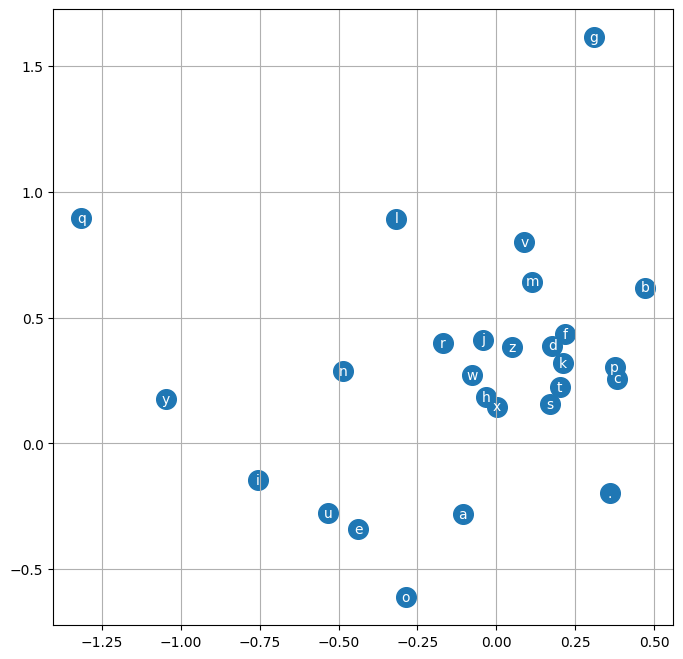

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

모델이 생각하기에
- 유사한 의미면 가깝게
- 다른 의미면 멀게   

표현합니다

# 임베딩 차원 늘리기

임베딩 벡터 차원: 2 -> 10차원   
대신 hidden layer는 300 -> 200차원   

In [57]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [58]:
sum(p.nelement() for p in parameters)

11897

In [ ]:
import torch.nn.functional as F

stepi = []
lossi = []
for i in range(50000):
    # minibatch 적용
    ix = torch.randint(0, Xtr.shape[0], (32,)) # batch size == 32
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Ytr[ix])
    loss.backward()
    # print(loss.item())

    lr = 0.1
    for p in parameters:
        p.data -= lr*p.grad
        p.grad=None

    stepi.append(i)
    lossi.append(loss.log10().item())
    
loss.item()

2.5247323513031006

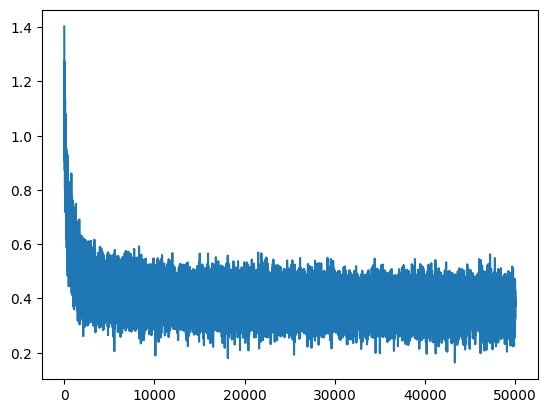

In [60]:
plt.plot(stepi, lossi)

In [65]:
# 전체 학습 데이터 loss
emb = C[Xtr] 
h = torch.tanh(emb.view(-1,30) @ W1 + b1) 
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.30238938331604


In [66]:
# val 데이터 loss
emb = C[Xval] 
h = torch.tanh(emb.view(-1,30) @ W1 + b1) 
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Yval)
print(loss.item())

2.326425313949585


# 마지막 코드 정리

In [69]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [70]:
for i in range(200000):
    # minibatch 적용
    ix = torch.randint(0, Xtr.shape[0], (32,)) # batch size == 32
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr*p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())
    
loss.item()

2.2616920471191406

In [71]:
# 전체 학습 데이터 loss
emb = C[Xtr] 
h = torch.tanh(emb.view(-1,30) @ W1 + b1) 
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.128556251525879


In [72]:
# val 데이터 loss
emb = C[Xval] 
h = torch.tanh(emb.view(-1,30) @ W1 + b1) 
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Yval)
print(loss.item())

2.1702394485473633


# 이름 짓기

In [75]:
block_size = 3
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):

    context = [0]*block_size

    out = []
    while True:
        emb = C[torch.tensor([context])]
        h = emb.view(1, -1) @ W1 + b1
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        if ix==0:
            break
        context = context[1:] + [ix]
        out.append(ix)

    print(''.join(itos[i] for i in out))

ups
ups
ups
ups
ups
ups
ups
ups
ups
ups
